<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [1]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

printOutput = False

os.makedirs('Bed_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/bed-availability-and-occupancy/bed-data-overnight/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "NHS organisations in England, Quarter" in elem.getText():
        page_names.append(elem.get('href'))
        
print("Total of {} pages found".format(len(page_names)))

Total of 38 pages found


C:\Users\David\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\David\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


<h2>Take data from xls files</h2>

In [2]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []


# Make vectorised int function
vecint = np.vectorize(int)

# Open first data set to get all of the hospital names 
# AttendenceData = np.zeros(len())

# Gather data that we actually want to use
data = page_names
        
###########################################
### Get names and initiate data storage ###
##########################################

resp = requests.get(data[0])
# Store the data in a temporary file
tempfile = open('tempfile.xls', 'wb')
tempfile.write(resp.content)
tempfile.close()
sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M,N")

# List of names from the first sheet
firstNames = sheet['Org Name'].values        

BedsAvail = np.zeros((len(firstNames), len(data)),dtype=object) 
BedsAvail[:,:] = '-'
OccBeds = np.zeros((len(firstNames), len(data)),dtype=object) 
OccBeds[:,:] = '-'
    
for i, name in enumerate(data):   
    # Get the data location
    resp = requests.get(name)

    # Store the data in a temporary file
    tempfile = open('tempfile.xls', 'wb')
    tempfile.write(resp.content)
    tempfile.close()

    # Get all of the data from row 16 with columns A to N
    # I don't think this is how try is supposed to be used but it works
    if not 'XLS-406K' in name:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,G,H,I,J,K")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=14, usecols="F,N,M,O,P,Q")
    else:
        sheet_avail = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,F,G,H,I")
        sheet_occ = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="E,L,M,N,O,P")
    #print(sheet)
    names = sheet_avail['Org Name'].values
    totalbeds = sheet_avail['Total '].values
    occbeds = sheet_occ['Total '].values
    
    for j, fname in enumerate(firstNames):
        if sum(names==fname) == 1:
            # Save attendance data
            beds = totalbeds[names==fname]
            assert len(beds) == 1
            BedsAvail[:,i][firstNames==fname] = beds
            
            # Save waiting data
            occ_beds = occbeds[names==fname]
            assert len(occ_beds) == 1
            OccBeds[:,i][firstNames==fname] = occ_beds
    
    print(i , names[0],names[1])

#     if printOutput == False:
#         print("{} complete of {}...".format(i+1,len(data)),end = "\r")

0 England nan
1 England nan
2 England nan
3 England nan
4 England nan
5 England nan
6 England nan
7 England nan
8 England nan
9 England nan
10 England nan
11 England nan
12 England nan
13 England nan
14 England nan
15 England nan
16 England nan
17 England nan
18 England nan
19 England nan
20 England nan
21 England nan
22 England nan
23 England nan
24 England nan
25 England nan
26 England nan
27 England nan
28 England nan
29 England nan
30 England nan
31 England nan
32 England nan
33 England nan
34 England nan
35 England nan
36 nan England
37 nan England


<h2> Check Plot</h2>

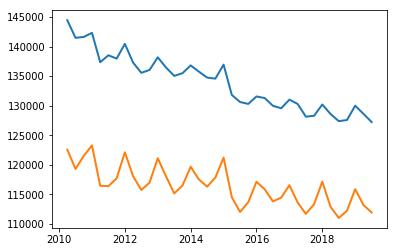

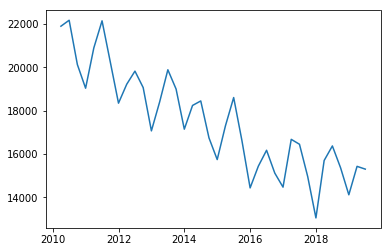

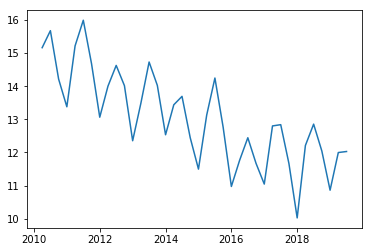

In [5]:
time = np.arange(2010.25, 2019.75, 0.25)[::-1]
allBeds = BedsAvail[0,:]
alloccBeds = OccBeds[0,:]
plt.plot(time, allBeds,lw=2)
plt.plot(time, alloccBeds,lw=2)
#plt.ylim(100000, 146000)
plt.show()

plt.plot(time, allBeds - alloccBeds)
plt.show()
plt.plot(time, (allBeds-alloccBeds)/allBeds*100)

In [ ]:
np.arange(2010.25, 2011.25, 0.25)

In [6]:
better = 0
worse = 0
change = np.zeros(len(firstNames[2:]))
for i, name in enumerate(firstNames[2:]):# 'BEDFORD HOSPITAL NHS TRUST'
    SampleBedsAvail = BedsAvail[firstNames == name][0]

    SampleBedsOcc = OccBeds[firstNames == name][0]

    remaining = (SampleBedsAvail[SampleBedsAvail != '-'] - SampleBedsOcc[SampleBedsOcc != '-'])
    change[i] = remaining[0]-remaining[-1]
    if change[i]>0:
        better+=1
    else:
        worse+=1


#plt.plot(time[BedfordBedsAvail != '-'], remaining,lw=2)

In [7]:
print(better, worse)
print("{:.3}%".format(129/(76+129)*100))

76 129
62.9%


C:\Users\David\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


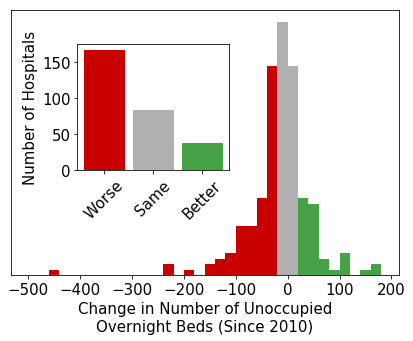

In [70]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=15)

fig, ax1 = plt.subplots(figsize = (6,5))

blue, gray, red, green = ['#3486eb', '#b0b0b0','#c90000', '#47a147']

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.5, 0.35, 0.35]
ax2 = fig.add_axes([left, bottom, width, height])

bins = np.arange(-500, 200, 20)
n, bins, patches = ax1.hist(change, bins=bins, color = gray);
ax1.hist(change[change<-20], bins=bins, color = red);
ax1.hist(change[change>20], bins=bins, color = green);
ax1.set_xlabel("Change in Number of Unoccupied\nOvernight Beds (Since 2010)")
ax1.set_yticks([])
better = len(change[change>20])
same = len(change[(change<=20)*(change>=-20)])
worse = len(change[change<20])

barlist = ax2.bar([0,1,2],[worse, same, better],tick_label = ['Worse','Same','Better'])
ax2.set_ylabel("Number of Hospitals")

for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    
barlist[0].set_color(red)
barlist[1].set_color(gray)
barlist[2].set_color(green)
plt.tight_layout()
plt.savefig("overnightbeds.jpg")
plt.show()
